# Making the Hadamard test (partition function) data figures

In [1]:
import joblib
from datetime import datetime

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

import seaborn as sns
from matplotlib import pyplot as plt

Set the knot we are interested in, supported options:
- 'trefoil'
- 'trefoil-twist'
- 'arc-trefoil' (called "closed trefoil" in the manuscript)
- 'arc-trefoil-twist' (called "closed trefoil+twist" in the manuscript)

In [18]:
knot = 'trefoil'

## Load the data

In [20]:
filename = 'unpacked_zne_data.joblib'
df = joblib.load(
    f'analysis/tmp/{knot}/{filename}'
)
df

,scale_factor,date_str,meas_err_mit,QV,target_val,data_src,date_int,part,mean_zne,std_zne,backend_name
0,1,25/06/21,0,32,0.0,"zne,richardson,3",1624612724,real,-0.085938,0.011008,ibmq_casablanca
1,1,25/06/21,0,32,0.0,"zne,richardson,5",1624612724,real,-0.087402,0.011007,ibmq_casablanca
2,1,25/06/21,0,32,0.0,"zne,richardson,7",1624612724,real,-0.084473,0.011010,ibmq_casablanca
3,1,25/06/21,0,32,0.0,"zne,richardson,9",1624612724,real,-0.093506,0.011001,ibmq_casablanca
4,1,25/06/21,0,32,0.0,"zne,linear,3",1624612724,real,-0.113037,0.010978,ibmq_casablanca
...,...,...,...,...,...,...,...,...,...,...,...
56555,9,01/07/21,0,16,0.5,"zne,linear,9",1625131463,imag,-0.000488,0.011049,ibmq_jakarta
56556,9,01/07/21,1,16,0.0,"zne,richardson,9",1625131463,real,0.038130,0.011041,ibmq_jakarta
56557,9,01/07/21,1,16,0.0,"zne,linear,9",1625131463,real,0.032261,0.011043,ibmq_jakarta
56558,9,01/07/21,1,16,0.5,"zne,richardson,9",1625131463,imag,-0.019816,0.011047,ibmq_jakarta


In [21]:
#
# there was a bug in our code for the arc-trefoil and 
# arc-trefoil-twist results. It can be corrected by multiplying
# the values in those cases by (+i)
#

def _fix_part(group):
    gidx = group['part'].iloc[0]
    if gidx == 'real':
        group['new_part'] = 'imag'
    elif gidx == 'imag':
        group['new_part'] = 'real'
        group['mean_zne'] = -1. * group['mean_zne']
        group['target_val'] = -1. * group['target_val']
    else:
        raise ValueError(f'group id {gidx} not recognized')
    return group

if knot in ['arc-trefoil', 'arc-trefoil-twist']:
    df = df.groupby('part').apply(_fix_part)
    df = df.drop(columns='part')
    df = df.rename(columns={'new_part': 'part'})

In [22]:
_devices = [
    'ibmq_lima',
    'ibmq_quito',
    'ibmq_paris',
    'ibmq_montreal',
]
df = df.loc[
    df['backend_name'].apply(lambda x: x in _devices)
]

In [23]:
df

,scale_factor,date_str,meas_err_mit,QV,target_val,data_src,date_int,part,mean_zne,std_zne,backend_name
4032,1,25/06/21,0,32,0.0,"zne,richardson,3",1624612724,real,-0.057617,0.011031,ibmq_paris
4033,1,25/06/21,0,32,0.0,"zne,richardson,5",1624612724,real,-0.064941,0.011026,ibmq_paris
4034,1,25/06/21,0,32,0.0,"zne,richardson,7",1624612724,real,-0.025635,0.011046,ibmq_paris
4035,1,25/06/21,0,32,0.0,"zne,richardson,9",1624612724,real,-0.045410,0.011038,ibmq_paris
4036,1,25/06/21,0,32,0.0,"zne,linear,3",1624612724,real,-0.061768,0.011028,ibmq_paris
...,...,...,...,...,...,...,...,...,...,...,...
44123,9,01/07/21,0,8,0.5,"zne,linear,9",1625131463,imag,0.014893,0.011048,ibmq_lima
44124,9,01/07/21,1,8,0.0,"zne,richardson,9",1625131463,real,0.085465,0.011009,ibmq_lima
44125,9,01/07/21,1,8,0.0,"zne,linear,9",1625131463,real,0.055981,0.011032,ibmq_lima
44126,9,01/07/21,1,8,0.5,"zne,richardson,9",1625131463,imag,-0.014104,0.011048,ibmq_lima


This shows the mean and std of the estimate of the without ZNE but with measurement error mitigation

In [9]:
df.loc[
    df['data_src'].apply(lambda x: ('7' in x) or ('9' in x))
    & (df['scale_factor'] == 1)
    & (df['meas_err_mit'] == 1)
].groupby(['part', 'backend_name'])['mean_zne'].agg(['mean', 'std']).reset_index()

,part,backend_name,mean,std
0,imag,ibmq_lima,0.557897,0.025260
1,imag,ibmq_montreal,0.487910,0.124911
2,imag,ibmq_paris,0.513401,0.045347
3,imag,ibmq_quito,0.466945,0.061219
4,real,ibmq_lima,0.422048,0.045740
5,real,ibmq_montreal,0.439980,0.113831
6,real,ibmq_paris,0.456354,0.050947
7,real,ibmq_quito,0.433467,0.069921


This shows the number of executions on each device

In [81]:
df.loc[
    df['data_src'].apply(lambda x: ('7' in x) or ('9' in x))
    & (df['scale_factor'] == 1)
    & (df['part'] == 'real')
    & (df['meas_err_mit'] == 1)
].groupby(['backend_name'])['date_str'].count().reset_index()

,backend_name,date_str
0,ibmq_lima,152
1,ibmq_montreal,132
2,ibmq_paris,128
3,ibmq_quito,156


## Plot execution timeline

/var/folders/jj/rmzjgrj1773b9l_n2mth4z6h0000gp/T/ipykernel_62294/2881620820.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
/var/folders/jj/rmzjgrj1773b9l_n2mth4z6h0000gp/T/ipykernel_62294/2881620820.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
/var/folders/jj/rmzjgrj1773b9l_n2mth4z6h0000gp/T/ipykernel_62294/2881620820.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
/var/folders/jj/rmzjgrj1773b9l_n2mth4z6h0000gp/T/ipykernel_62294/2881620820.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


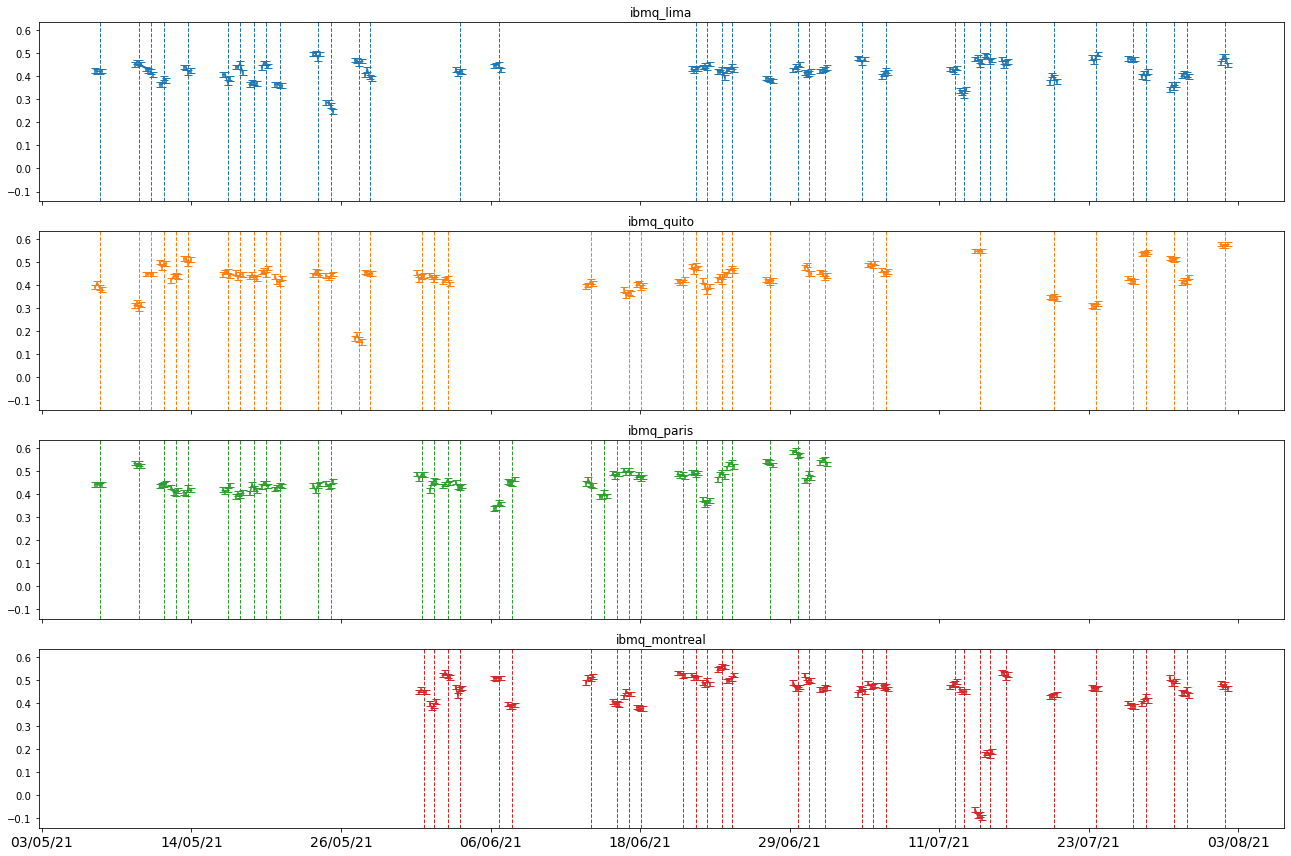

In [11]:
part = 'real'

nrows = len(_devices)
fig, axs = plt.subplots(
    nrows=nrows,
    figsize=(18, 3*nrows),
    sharex=True, sharey=True,
)

for dev_idx, dev in enumerate(_devices):
    ax = axs[dev_idx]

    _df = df.loc[
        (df['part'] == part)
        & (df['backend_name'] == dev)
        & (df['scale_factor'] == 1)
        & (df['meas_err_mit'] == 1)
        & (df['data_src'].apply(lambda x: ('7' in x) or ('9' in x)))
    ]
    _df_min_and_max = _df.groupby('date_int')['mean_zne'].agg(['min', 'max']).reset_index()

    ax.set_title(f'{dev}')

    for val in _df['date_int'].unique():
        ax.axvline(
            x=val, color=f'C{dev_idx}', 
            linestyle='--', linewidth=1.,
        )

    _jitter = 15000
    for name, group in _df.groupby(['date_int']):
        ax.errorbar(
            name + _jitter*(np.arange(group.shape[0])-group.shape[0]//2),
            group['mean_zne'],
            yerr=group['std_zne'],
            marker=None,
            color=f'C{dev_idx}',
            capsize=4,
        )
    
    tick_positions = ax.get_xticks()
    ax.set_xticklabels(
        [datetime.fromtimestamp(date_val).strftime("%d/%m/%y") for date_val in tick_positions],
        fontsize=14,
    )

plt.tight_layout()
plt.show()

## Boxen plots dropping date information

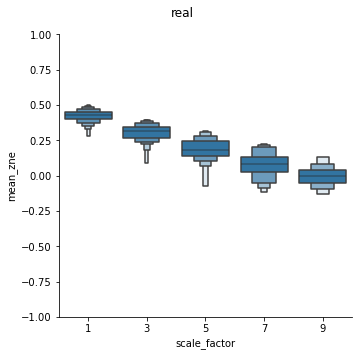

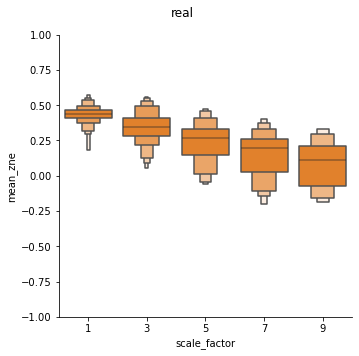

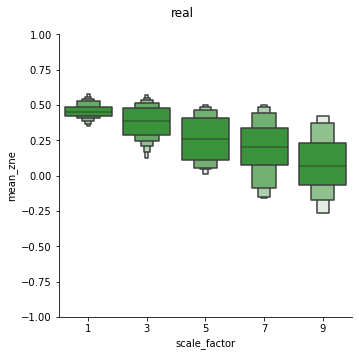

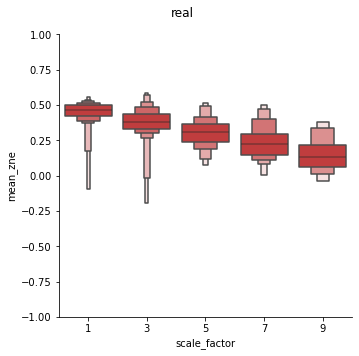

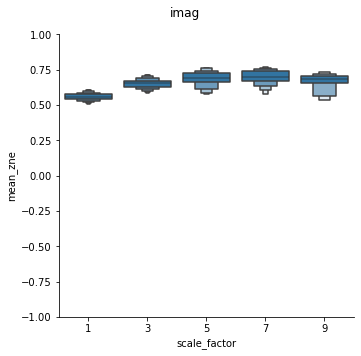

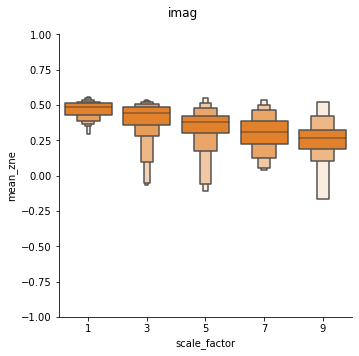

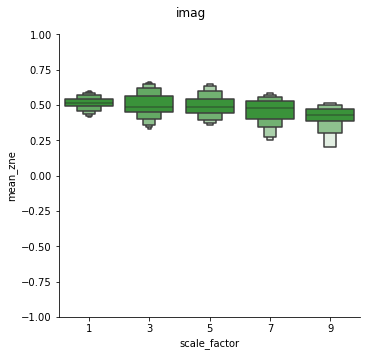

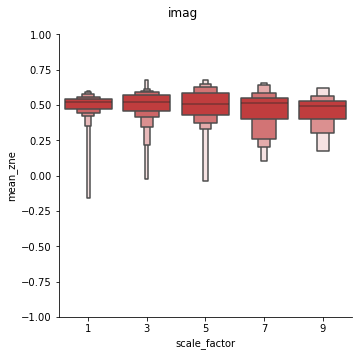

In [12]:
for part in ['real', 'imag']:
    for didx, device in enumerate(_devices):
        g = sns.catplot(
            x='scale_factor', y='mean_zne',
            data=df.loc[
                (df['part']==part)
                & (df['meas_err_mit']==1)
                & (df['backend_name']==device)
            ],
            kind='boxen', showfliers=False,
            color=f'C{didx}'
            # height=3, aspect=0.5,
        )
        g.fig.suptitle(f'{part}')
        g.fig.tight_layout()
        for ax in g.axes[0]:
            ax.axes.set_ylim(-1, 1)
        # plt.savefig(f'analysis/figs/parts/{knot}/{knot}_catplot_{part}_{device}.pdf', bbox_inches='tight')

## Fits to the pooled data

In [13]:
def exp_fit(x, a, b):
    return a*np.exp(-b*x)

def lin_fit(x, a, b):
    return a + b*x

In [16]:
target_vals = df.groupby(['part'])['target_val'].mean().reset_index()
target_vals

,part,target_val
0,imag,0.5
1,real,0.5


[0.49983184 0.16305011]
[[0.01166896 0.0111989 ]
 [0.0111989  0.01236439]]
[0.54847933 0.22776484]
[[0.01433634 0.01068437]
 [0.01068437 0.01012264]]
[ 0.48371194 -0.05908049]
[[0.00944999        nan]
 [       nan 0.00431202]]
[ 0.48588152 -0.0604168 ]
[[0.00909321        nan]
 [       nan 0.00273562]]


/var/folders/jj/rmzjgrj1773b9l_n2mth4z6h0000gp/T/ipykernel_62294/3230914187.py:52: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(pcov))


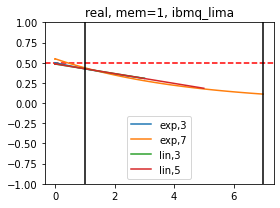

[0.48929499 0.10951025]
[[0.01933824 0.01828284]
 [0.01828284 0.01975317]]
[0.52321361 0.15300421]
[[0.0201649  0.01407971]
 [0.01407971 0.01230126]]
[ 0.48167131 -0.04312944]
[[0.01684593        nan]
 [       nan 0.00764303]]
[ 0.48933951 -0.04781809]
[[0.01557543        nan]
 [       nan 0.00466503]]


/var/folders/jj/rmzjgrj1773b9l_n2mth4z6h0000gp/T/ipykernel_62294/3230914187.py:52: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(pcov))


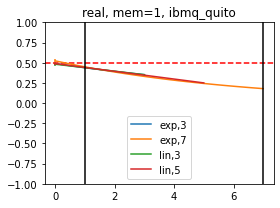

[0.49894827 0.0835524 ]
[[0.01917773 0.01775603]
 [0.01775603 0.01870988]]
[0.53235552 0.12580191]
[[0.02312738 0.0155409 ]
 [0.0155409  0.0129294 ]]
[ 0.49426802 -0.035314  ]
[[0.01728212        nan]
 [       nan 0.00782434]]
[ 0.50991399 -0.04485443]
[[0.01721406        nan]
 [       nan 0.00515674]]


/var/folders/jj/rmzjgrj1773b9l_n2mth4z6h0000gp/T/ipykernel_62294/3230914187.py:52: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(pcov))


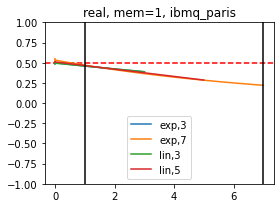

[0.48615683 0.0860701 ]
[[0.02625392 0.02465093]
 [0.02465093 0.02635304]]
[0.49351982 0.09548776]
[[0.01881813 0.01274269]
 [0.01274269 0.01053233]]
[ 0.48133341 -0.03526998]
[[0.0235821         nan]
 [       nan 0.01067849]]
[ 0.48094492 -0.03503304]
[[0.01747608        nan]
 [       nan 0.00522738]]


/var/folders/jj/rmzjgrj1773b9l_n2mth4z6h0000gp/T/ipykernel_62294/3230914187.py:52: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(pcov))


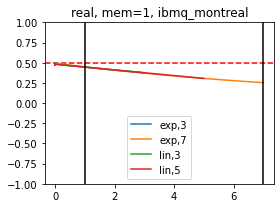

[6.11771695e-01 1.99212938e-24]
[[0.01079953 0.00861666]
 [0.00861666 0.00761206]]
[6.59675064e-01 3.53958195e-17]
[[0.00886294 0.0047056 ]
 [0.0047056  0.0028103 ]]
[0.5096814  0.04874171]


/var/folders/jj/rmzjgrj1773b9l_n2mth4z6h0000gp/T/ipykernel_62294/3230914187.py:52: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(pcov))


[[0.00560803        nan]
 [       nan 0.00241823]]
[0.53654605 0.03342037]
[[0.00600985        nan]
 [       nan 0.0016815 ]]


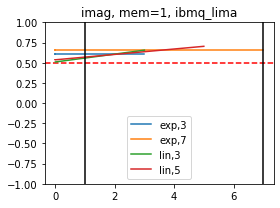

[0.50880804 0.0769164 ]
[[0.02039068 0.01863893]
 [0.01863893 0.01936602]]
[0.50463788 0.07230277]
[[0.01680706 0.01100338]
 [0.01100338 0.00867447]]
[ 0.50472822 -0.03358863]
[[0.01853359        nan]
 [       nan 0.00838137]]
[ 0.49958886 -0.03045944]
[[0.01640688        nan]
 [       nan 0.00488538]]


/var/folders/jj/rmzjgrj1773b9l_n2mth4z6h0000gp/T/ipykernel_62294/3230914187.py:52: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(pcov))


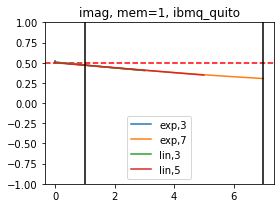

[0.52269691 0.00853539]
[[0.01381648 0.01212251]
 [0.01212251 0.01191477]]
[0.53274336 0.01675746]
[[0.01033091 0.00627575]
 [0.00627575 0.00441965]]
[ 0.52264043 -0.00438596]
[[0.01367522        nan]
 [       nan 0.00612182]]
[ 0.52197466 -0.00398597]
[[0.01109728        nan]
 [       nan 0.00325814]]


/var/folders/jj/rmzjgrj1773b9l_n2mth4z6h0000gp/T/ipykernel_62294/3230914187.py:52: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(pcov))


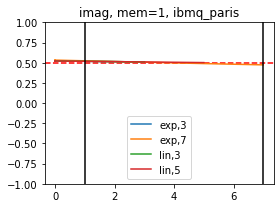

[5.02005641e-01 1.65636538e-17]
[[0.02224558 0.0198354 ]
 [0.0198354  0.01975931]]
[0.50612939 0.00470962]
[[0.0170452  0.0105023 ]
 [0.0105023  0.00742835]]
[0.49142704 0.00526985]
[[0.02222142        nan]
 [       nan 0.00990851]]
[0.49930499 0.00056166]
[[0.01946019        nan]
 [       nan 0.00567924]]


/var/folders/jj/rmzjgrj1773b9l_n2mth4z6h0000gp/T/ipykernel_62294/3230914187.py:52: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(pcov))


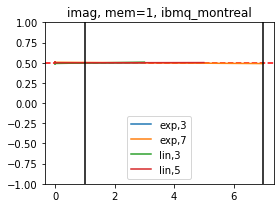

In [17]:
mem = 1
for part in ['real', 'imag']:
    for device in _devices:

        nrows = 1
        ncols = 1
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows))

        _ax_select = (
            (df['part'] == part)
            & (df['backend_name'] == device)
            & (df['meas_err_mit'] == 1)
        )

        _offset = df.loc[
            _ax_select
            & (df['scale_factor'] == 9)
        ]['mean_zne'].median()
        def _exp_fit(x, a, b,):
            return _offset + exp_fit(x, a, b,)

        ax.set_title(f'{part}, mem={mem}, '+device)

        ax.axhline(
            target_vals.loc[(target_vals['part']==part)]['target_val'].values[0],
            color="r", linestyle='--'
        )

        for label_name, fitter, bounds in zip(
            ['exp,3', 'exp,7', 'lin,3', 'lin,5'],
            [exp_fit, exp_fit, lin_fit, lin_fit],
            [([-1., 0], [1., np.inf]), ([-1., 0], [1., np.inf]), (-np.inf, np.inf), (-np.inf, np.inf)],
        ):

            _select = (
                _ax_select
                & (df['scale_factor'] < int(label_name.split(',')[1])+1)
                & (df['data_src'].apply(lambda x: '9' in x))
            )
            _x = np.linspace(0, int(label_name.split(',')[1]), 100)

            try:
                popt, pcov = curve_fit(
                    fitter,
                    df.loc[_select]['scale_factor'].values,
                    df.loc[_select]['mean_zne'].values,
                    sigma=df.loc[_select]['std_zne'].values,
                    bounds=bounds,
                    # absolute_sigma=True,
                )
                print(popt)
                print(np.sqrt(pcov))

                line, = ax.plot(_x, fitter(_x, *popt,), '-', label=label_name)
                ax.errorbar([0], [fitter(0, *popt)], yerr=[np.sqrt(pcov[0, 0])], color=line.get_color())
            except RuntimeError:
                continue

        ax.axvline(x=1, color='k')
        ax.axvline(x=7, color='k')
        ax.set_ylim(-1, 1)

        plt.legend()
        # plt.savefig(f'analysis/figs/parts/{knot}/{knot}_fits_{part}_{device}.pdf', bbox_inches='tight')
        plt.tight_layout()
        plt.show()